# IMAGE RECOGNITION ON FLOWER DATASET: DANDELION & DAISY

Image Classification Using Swin Transformer
Image_resolution = 224 x 224

patch_size = 4 x 4

number of features in one patch = 4 x 4 x 3 = 48

total number of patches in the whole image = 224/4 x 224/4 = 3136

In [1]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [2]:
# This code cell needs to be edited.
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



# Load the image file
image_path = 'C:/Users/sharm/Downloads/test/class_2/das10.jpg'
image = Image.open(image_path)



# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])


# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

# Print the shape and data type of the tensor
print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

# Permute dimensions to match the expected shape (B, H, W, C)
tensor_image = tensor_image.permute(0, 2, 3, 1)

Tensor shape: torch.Size([1, 3, 224, 224])
Tensor data type: torch.float32


In [3]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)
        
    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """
    
    B, H, W, C = x.shape
    
    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C) 
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    
    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    
    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)
    
    return patches

Windows shape: torch.Size([3136, 4, 4, 3])
num_patches  3136


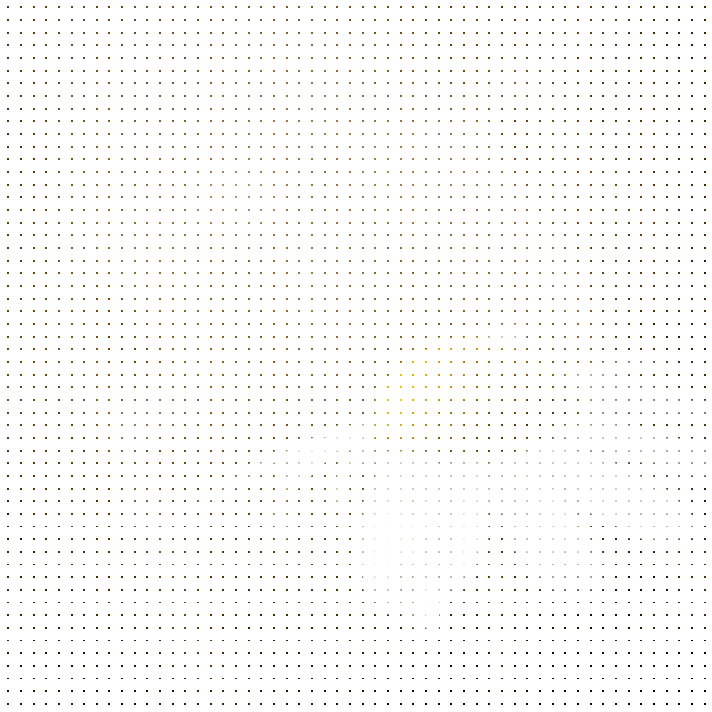

In [4]:
#  This code cell needs to be edited.
#  Call the window_partition function on the tensor_image
window_size = 4
windows = window_partition(tensor_image, window_size)

num_patches, patch_size, _, _ = windows.shape

# Print the shape of the output windows
print("Windows shape:", windows.shape)

print("num_patches ",num_patches)

# Calculate the number of rows and columns in the grid
num_rows = int(num_patches ** 0.5)
num_cols = num_patches // num_rows

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the patches and plot them
for i, ax in enumerate(axs.flat):
    patch = windows[i].numpy()
    ax.imshow(patch)
    ax.axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# (224/4 * 224/4 =56*56 = 3136 patches of size 4*4)

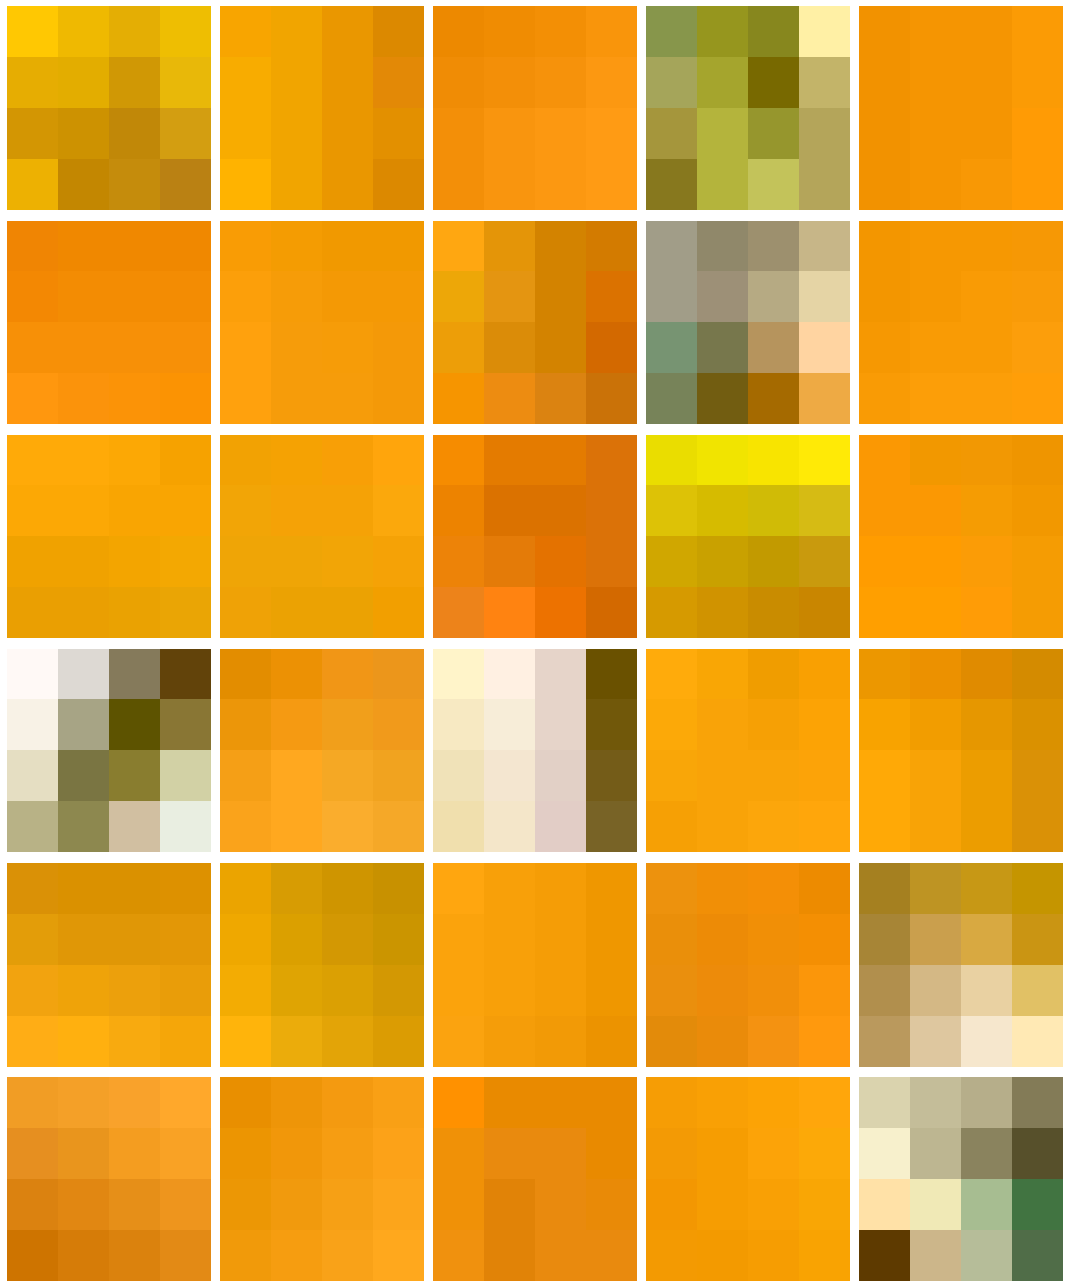

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display
num_images = 30

# Randomly select 20 indices
indices = np.random.choice(windows.shape[0], num_images, replace=False)

# Set up the figure and axes
num_cols = 5
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate

for ax, idx in zip(axes, indices):
    window = windows[idx]  # Get a single window
    
    # Convert the window tensor to a numpy array and transpose dimensions
    window_np = window.numpy().transpose(1, 0, 2)
    
    # Normalize the window values to [0, 1] range
    window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())
    
    # Display the window image
    ax.imshow(window_np)
    ax.axis('off')

# Hide any unused subplots
for i in range(len(indices), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [6]:
# Lets use PatchEmbed

class PatchEmbed(nn.Module):
    """ Convert image to patch embedding
    
    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """
    
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]
        
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None
        
    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)
        
        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)
        
        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x

In [7]:
# Load the image file
image_path = 'C:/Users/sharm/Downloads/test/class_1/dan9.jpg'
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image) 
# Print the shape of the output patches
print("Patches shape:", patches.shape)   # 96 is embedding dimension, 3136 patches 224/4 * 224/4

embedding

Patches shape: torch.Size([1, 3136, 96])


tensor([[[-0.0831,  0.2993,  0.0702,  ...,  0.0731, -0.0226,  0.0552],
         [-0.0917,  0.3922,  0.0889,  ...,  0.1301, -0.0842, -0.0423],
         [-0.0737,  0.3433,  0.0958,  ...,  0.1563, -0.0899,  0.0183],
         ...,
         [-0.1365,  0.4774,  0.1069,  ...,  0.1508, -0.1158, -0.0201],
         [-0.0768,  0.3394,  0.0846,  ...,  0.1051, -0.0865,  0.0525],
         [-0.1248,  0.4260,  0.1031,  ...,  0.1294, -0.0893,  0.0286]]],
       grad_fn=<TransposeBackward0>)

In [8]:
print("First patch embedding vector:", patches[0, 0])

# 96 values in every patch because 96 is embedding dimension we mentioned above

#To access the second patch's embedding vector, you can use patches[0, 1]

First patch embedding vector: tensor([-0.0831,  0.2993,  0.0702, -0.1141,  0.0007, -0.0640,  0.0693,  0.0598,
        -0.1722, -0.0659,  0.1695,  0.0164, -0.2744,  0.0524, -0.0360, -0.1872,
         0.0027,  0.0024,  0.0006, -0.0024,  0.0183, -0.0356, -0.1678, -0.1472,
        -0.1466, -0.1109, -0.0681,  0.0812, -0.0393, -0.0717,  0.0521,  0.1876,
        -0.0757,  0.2349,  0.1055,  0.1425, -0.0897,  0.0387, -0.0258,  0.1035,
         0.0661, -0.1531,  0.0900, -0.0185, -0.0797,  0.1398, -0.0830,  0.1175,
         0.2120, -0.0565, -0.0370, -0.1624, -0.1064,  0.0180, -0.2019,  0.0051,
        -0.1491,  0.1500, -0.1422, -0.0132, -0.1732, -0.1176,  0.1979,  0.2186,
         0.1009, -0.1242, -0.1018,  0.1559,  0.1933,  0.0538, -0.0792,  0.0900,
         0.2027,  0.0044,  0.0243,  0.0690, -0.1101, -0.0826,  0.0501,  0.0558,
        -0.0612, -0.0163,  0.0533,  0.0178,  0.0199,  0.0477, -0.1544, -0.1436,
        -0.0238,  0.0020, -0.0115, -0.1084, -0.0668,  0.0731, -0.0226,  0.0552],
       gr

In [9]:
import torch.nn as nn

class BasicLayer(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size):
        super(BasicLayer, self).__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.num_heads = num_heads
        self.window_size = window_size

        # Define layer components here (e.g., window-based multi-head self-attention, MLP, etc.)
        self.attention = nn.MultiheadAttention(embed_dim=self.dim, num_heads=self.num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(self.dim, self.dim * 4),
            nn.GELU(),
            nn.Linear(self.dim * 4, self.dim)
        )

    def forward(self, x):
        # Apply the attention mechanism and MLP
        attn_output, _ = self.attention(x, x, x)
        output = self.mlp(attn_output)
        return output

# Create an instance of BasicLayer
stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Simulated patch embeddings for testing (replace with actual embeddings in practice)
embedding = torch.randn(1, 56 * 56, 96)  # Example: (batch_size, num_patches, embedding_dim)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)


torch.Size([1, 3136, 96])


In [10]:
import torch
import torch.nn as nn

class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        """
        Patch Merging Layer in Swin Transformer

        Args:
            input_resolution (tuple): Height and Width of the input resolution.
            dim (int): Number of input channels.
            norm_layer (nn.Module): Normalization layer.
        """
        super(PatchMerging, self).__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        Forward function for Patch Merging.

        Args:
            x (torch.Tensor): Input tensor with shape (B, H*W, C).

        Returns:
            torch.Tensor: Output tensor after patch merging.
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "Input feature has wrong size"

        # Reshape to (B, H, W, C)
        x = x.view(B, H, W, C)

        # Merging the patches (each 2x2 window will be merged into 1 patch)
        x0 = x[:, 0::2, 0::2, :]  # top-left
        x1 = x[:, 1::2, 0::2, :]  # bottom-left
        x2 = x[:, 0::2, 1::2, :]  # top-right
        x3 = x[:, 1::2, 1::2, :]  # bottom-right

        # Concatenate along the channel dimension
        x = torch.cat([x0, x1, x2, x3], dim=-1)  # Shape: (B, H//2, W//2, 4*C)

        # Reshape and apply layer normalization and linear transformation
        x = x.view(B, -1, 4 * C)  # Shape: (B, H//2 * W//2, 4*C)
        x = self.norm(x)
        x = self.reduction(x)

        return x


In [11]:
# PatchMerging

# USing patch merging on the embedding
merge_layer = PatchMerging(input_resolution=(56, 56), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)    # (1, 28x28, 96*2) # (1, 784, 192)

Merged output shape: torch.Size([1, 784, 192])


In [12]:
batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)

Batch size: 1
Number of patches: 784
Number of channels: 192


In [13]:
import torch
import torch.nn as nn

class WindowAttention(nn.Module):
    """ Window based multi-head self-attention (W-MSA) module with relative position bias. """
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super(WindowAttention, self).__init__()
        self.dim = dim
        self.window_size = window_size  # Window size (Wh, Ww)
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super(SwinTransformerBlock, self).__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        if min(self.input_resolution) <= self.window_size:
            # If window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(dim, window_size=self.window_size, num_heads=num_heads,
                                    qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = nn.Identity()  # No stochastic depth in this simplified version
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            act_layer(),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = shortcut + self.drop_path(x)

        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


In [14]:
# Example input: simulated embeddings
embedding = torch.randn(1, 56 * 56, 96)  # Shape: (batch_size, num_patches, embedding_dim)

# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)

# Create another block with shift size
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)

# Pass the embedding through the SwinTransformerBlock
output = block_1(embedding)
output_shf = block_1_shf(embedding)

# Print shapes of outputs
print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[-0.0579,  0.5185, -1.1943,  ..., -2.2516,  0.5340, -0.2664],
         [ 0.8603,  0.0324, -0.4324,  ..., -0.5418, -0.2005, -1.7630],
         [ 0.8161,  0.0563, -0.4784,  ...,  0.8479, -0.8585, -0.1767],
         ...,
         [ 0.2683, -0.6774, -1.0928,  ..., -1.2415,  0.8807,  2.1484],
         [ 0.0295,  1.4006,  1.4201,  ...,  0.4928,  0.6818,  0.0087],
         [-0.1157,  2.7592,  0.2367,  ..., -1.0493,  2.1544,  1.4182]]],
       grad_fn=<AddBackward0>)
tensor([[[ 0.0436,  0.4521, -1.1023,  ..., -2.4569,  0.6013, -0.4798],
         [ 0.9645, -0.3350, -0.6409,  ..., -0.4371,  0.2180, -1.7780],
         [ 1.2627, -0.7317, -0.6468,  ...,  1.1729, -0.8966, -0.2040],
         ...,
         [ 0.5959, -1.0501, -1.3151,  ..., -1.7193,  1.1274,  1.9612],
         [ 0.2563,  1.7117,  1.3122,  ...,  1.4846,  0.5293, -0.1022],
         [-0.1782,  2.5227,  0.1677,  ..., -1.2018,  1.9881,  1.2551]]],
       grad_fn=<AddBackward0>)


In [15]:
import torch
import torch.nn as nn
from einops import rearrange

class PatchEmbedding(nn.Module):
    """ Patch Embedding for Swin Transformer. """
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size // patch_size, img_size // patch_size)
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # B, C, H, W -> B, num_patches, embed_dim
        x = self.proj(x)  # Apply the conv layer
        x = rearrange(x, "b c h w -> b (h w) c")
        return x

class SwinTransformer(nn.Module):
    def __init__(self, img_size=224, num_classes=1000, embed_dim=96):
        super(SwinTransformer, self).__init__()

        self.patch_embed = PatchEmbedding(img_size=img_size, patch_size=4, in_chans=3, embed_dim=embed_dim)

        # For simplicity, let's assume 2 stages with SwinTransformerBlock (you can extend with more)
        self.stage_1 = SwinTransformerBlock(dim=embed_dim, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)

        self.stage_2 = SwinTransformerBlock(dim=embed_dim, input_resolution=(28, 28), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Patch embedding
        x = self.patch_embed(x)

        # Pass through stages
        x = self.stage_1(x)
        x = self.stage_2(x)

        # Apply normalization and classification head
        x = self.norm(x.mean(dim=1))  # Global average pooling
        x = self.head(x)
        return x


In [16]:
# Create random tensor to simulate an input image batch
tensor_image = torch.randn(1, 3, 224, 224)  # Shape: (batch_size, channels, height, width)

# Initialize the Swin Transformer model
model = SwinTransformer(img_size=224, num_classes=10)  # For example, 10 classes

# Pass the image tensor through the model
output = model(tensor_image)

# Print output shape
print("Output shape:", output.shape)  # Expected: (batch_size, num_classes)


Output shape: torch.Size([1, 10])


In [17]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

In [18]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Concatenate the current directory with additional directories
train_dir = os.path.join(current_directory, "C:/Users/sharm/Downloads/train")
test_dir = os.path.join(current_directory, "C:/Users/sharm/Downloads/test")

# Print the directories to check
print("Train Directory:", train_dir)
print("Test Directory:", test_dir)


Train Directory: C:/Users/sharm/Downloads/train
Test Directory: C:/Users/sharm/Downloads/test


In [19]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,)
  
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [20]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [30]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define your transforms
manual_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Adjust to your needs
    transforms.ToTensor(),
])

# Create DataLoader
train_dataloader = DataLoader(
    datasets.ImageFolder(root='C:/Users/sharm/Downloads/train', transform=manual_transforms),
    batch_size=32,
    shuffle=True,
    num_workers=4
)

test_dataloader = DataLoader(
    datasets.ImageFolder(root='C:/Users/sharm/Downloads/test', transform=manual_transforms),
    batch_size=32,
    shuffle=False,
    num_workers=4
)

# Get class names
class_names = train_dataloader.dataset.classes


torch.Size([3, 128, 128]) tensor(0)


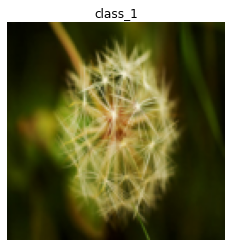

In [31]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [32]:
model = SwinTransformer(num_classes=len(class_names))

In [33]:
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch."""
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch."""
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model."""
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [34]:
import torch
import random
import numpy as np

def set_seeds(seed: int = 42):
    """Set seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if using multi-GPU.


In [35]:
"""
A series of helper functions used throughout the course.

If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
    
    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

In [36]:
import torch
#from helper_functions import set_seeds  # Ensure this is defined in your script or imported correctly

device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup the optimizer
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=3e-3, 
                             betas=(0.9, 0.999), 
                             weight_decay=0.3)

# Setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

# Optionally, print or save the results
print(results)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9433 | train_acc: 0.5000 | test_loss: 2.6659 | test_acc: 0.5000
Epoch: 2 | train_loss: 2.6583 | train_acc: 0.5000 | test_loss: 1.9250 | test_acc: 0.5000
Epoch: 3 | train_loss: 1.9480 | train_acc: 0.5000 | test_loss: 1.0420 | test_acc: 0.5000
Epoch: 4 | train_loss: 1.0775 | train_acc: 0.5000 | test_loss: 0.6499 | test_acc: 0.7500
Epoch: 5 | train_loss: 0.6461 | train_acc: 0.6875 | test_loss: 0.8767 | test_acc: 0.5000
Epoch: 6 | train_loss: 0.8340 | train_acc: 0.5000 | test_loss: 0.9993 | test_acc: 0.5000
Epoch: 7 | train_loss: 0.9505 | train_acc: 0.5000 | test_loss: 0.9357 | test_acc: 0.5000
Epoch: 8 | train_loss: 0.8921 | train_acc: 0.5000 | test_loss: 0.7983 | test_acc: 0.5000
Epoch: 9 | train_loss: 0.7662 | train_acc: 0.5000 | test_loss: 0.6912 | test_acc: 0.5000
Epoch: 10 | train_loss: 0.6739 | train_acc: 0.5000 | test_loss: 0.6642 | test_acc: 0.7500
{'train_loss': [0.94325852394104, 2.6582822799682617, 1.9479902982711792, 1.0774885416030884, 0.6461249589920

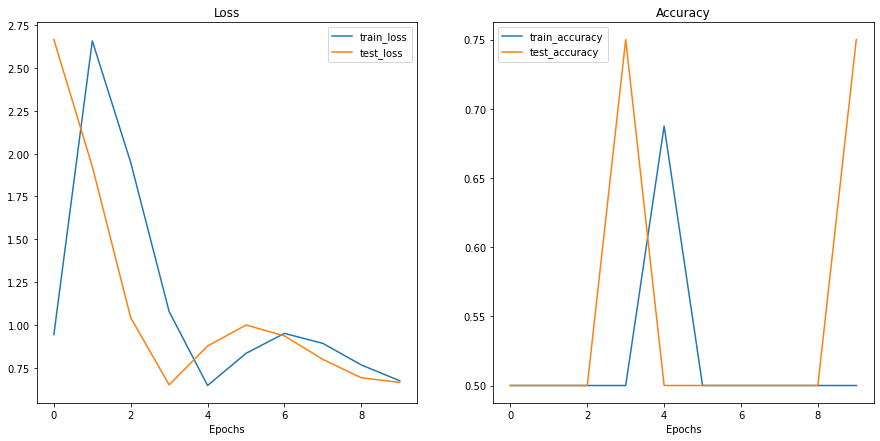

In [37]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
#from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

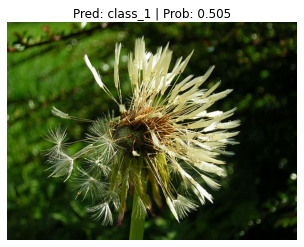

In [38]:
import requests

# Import function to make predictions on images and plot them 
#from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "C:/Users/sharm/Downloads/test/class_1/dan10.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

# DETAILED EXPLANATION & WORKING OF ABOVE CODE

Image Recognition Setup:

The code sets up an image recognition task for classifying flowers, specifically dandelions and daisies.
It uses a Swin Transformer model, which is a hierarchical vision transformer.


Data Preparation:

The code defines image size (224x224) and patch size (4x4).
It calculates the number of patches and features per patch.


Model Architecture:

The code implements several key components of the Swin Transformer:
a. PatchEmbed: Converts the input image into patch embeddings.
b. WindowAttention: Implements the window-based multi-head self-attention mechanism.
c. SwinTransformerBlock: The basic building block of the Swin Transformer.
d. PatchMerging: Reduces the resolution of feature maps between stages.


Data Loading:

The code sets up data loaders for training and testing datasets.
It applies transformations to resize images and convert them to tensors.


Training Loop:

The train_step and test_step functions define the training and testing procedures for each epoch.
The train function orchestrates the entire training process over multiple epochs.


Model Training:

The code initializes the SwinTransformer model, optimizer (Adam), and loss function (CrossEntropyLoss).
It then trains the model for 10 epochs using the defined training loop.


Visualization and Evaluation:

The code includes functions to plot loss curves and make predictions on individual images.
After training, it plots the training and testing loss/accuracy curves.
Finally, it makes a prediction on a custom test image and visualizes the result.



Key Concepts:

The Swin Transformer uses a hierarchical structure, processing image patches at different scales.
It employs shifted windows to create connections between windows from the previous layer.
The model alternates between window-based multi-head self-attention and patch merging, gradually increasing the receptive field.

This implementation demonstrates how to set up, train, and evaluate a Swin Transformer model for image classification tasks, specifically tailored for flower recognition between dandelions and daisies.